# Setup

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1eCJz8mommzUbqhIvGm0GHx2AlR_Iw01V&authuser=0&export=download --folder
!unzip dataset.zip
!rm -rf dataset.zip

## Functions and Constants

In [ ]:
RANDON_STATE = 42
ITERATIONS_OF_DATA_AUGMENTATION = 100

covid_class = ['non-COVID', 'COVID']
data_dir = 'dataset/'
train_dir = os.path.join(data_dir)
IMAGE_SIZE = 64

PATH_FOR_IMG_AUGMENTATION_COVID = 'aug/covid_class/'
PATH_FOR_IMG_AUGMENTATION_NON_COVID = 'aug/non_covid_class/'

COVID_DATA_PATH = 'dataset/COVID'
NON_COVID_DATA_PATH = 'dataset/non-COVID'

In [ ]:
def create_data_frame():
    train_data = []
    for defects_id, sp in enumerate(covid_class):
        for file in os.listdir(os.path.join(train_dir, sp)):
            train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
    return pd.DataFrame(train_data, columns=[
        'file', 'id_class', 'class'])

In [ ]:
def random_data_frame(data):
    data = data.sample(frac=1, random_state=RANDON_STATE)
    data.index = np.arange(len(data))
    return data

In [ ]:
def read_image(filepath, in_rgb):  # Loading a color image is the default flag
    return cv2.imread(os.path.join(data_dir, filepath), in_rgb)

In [ ]:
def resize_image(image, image_size):  # Resize image to target size
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
def load_images(data, in_rgb):
    grayscale_shape = (data.shape[0], IMAGE_SIZE, IMAGE_SIZE)
    color_shape = (data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)

    X_train = None

    if (in_rgb == 1):
      X_train = np.zeros(color_shape)
    else:
      X_train = np.zeros(grayscale_shape)

    print(X_train.shape)

    for i, file in tqdm(enumerate(data['file'].values)):
        image = read_image(file, in_rgb)
        if image is not None:
            X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
    print("Total de imagens carregadas: " + str(len(X_train)))
    return X_train

In [ ]:
def image_data_gen():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest',
    )

In [ ]:
def create_augmentation_for_images(from_path, save_to_path, n_iter):
  img_gen = image_data_gen()
  aug_images = img_gen.flow_from_directory(
      from_path,
      target_size=(IMAGE_SIZE, IMAGE_SIZE),
      save_to_dir=save_to_path,
      class_mode = None,
      save_prefix='generated_',
      batch_size=100,
      color_mode="rgb",
      subset=None,
  )

  for x in range(0, n_iter):
    aug_images.next()

In [ ]:
def get_reshape_from_3d_to_1d(data):
  return (data.shape[0], IMAGE_SIZE * IMAGE_SIZE * 3)

In [ ]:
def get_reshape_from_2d_to_1d(data):
  return (data.shape[0], data.shape[1] * data.shape[2])

In [ ]:
def plot_metrics(y_test, y_pred, model):
  # Metrics
  print(classification_report(y_test, y_pred, target_names=['non-covid', 'covid']))

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()
  plt.show()

  # ROC Curve
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  plt.plot(false_positive_rate, true_positive_rate, label='Best Model ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()



# GrayScale vs RGB

> Section running models with original dataset comparing images imported in Grayscale against RGB.



### Grayscale Model

In [ ]:
data = create_data_frame()
data = random_data_frame(data)
images = load_images(data, in_rgb = 0)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images, y_targets, test_size=0.2, stratify=data['id_class'])

(2481, 64, 64)


2481it [00:20, 123.78it/s]


Total de imagens carregadas: 2481


In [ ]:
model = make_pipeline(LogisticRegression())

In [ ]:
X_train = X_train.reshape(get_reshape_from_2d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_2d_to_1d(X_test))

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('logisticregression', LogisticRegression())])

In [ ]:
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

   non-covid       0.81      0.87      0.84       246
       covid       0.87      0.80      0.83       251

    accuracy                           0.84       497
   macro avg       0.84      0.84      0.84       497
weighted avg       0.84      0.84      0.84       497



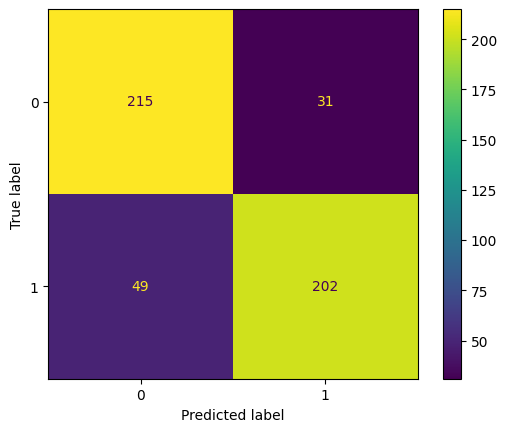

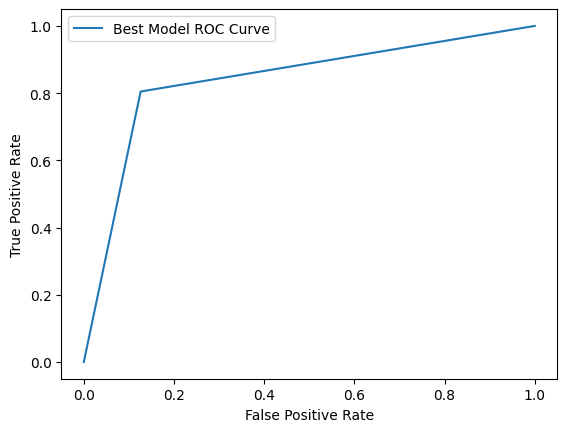

In [ ]:
plot_metrics(y_test, y_pred, model)

### RGB Model

In [ ]:
data = create_data_frame()
data = random_data_frame(data)
images_in_rgb = load_images(data, in_rgb=1)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images_in_rgb,
    y_targets,
    test_size=0.2,
    stratify=data['id_class'],
    random_state=RANDON_STATE
)


(2481, 64, 64, 3)


2481it [00:16, 154.58it/s]


Total de imagens carregadas: 2481


In [ ]:
X_train = X_train.reshape(get_reshape_from_3d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_3d_to_1d(X_test))


model = make_pipeline(LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
accuracy_score(y_test, y_pred)

0.8189134808853119

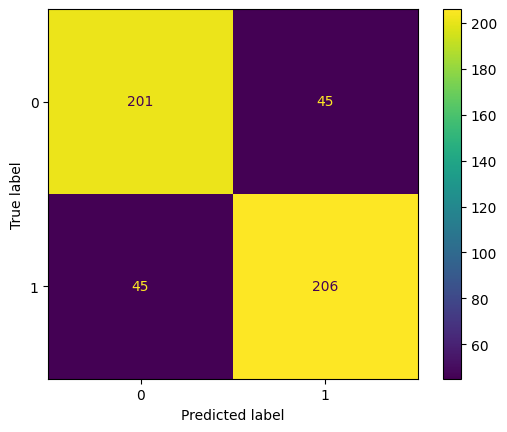

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

### Results of GrayScale vs RGB


> GrayScale model had a slightly improvement over RGB



# Optimizing

In [ ]:
data = create_data_frame()
data = random_data_frame(data)
images = load_images(data, in_rgb = 0)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images, y_targets, test_size=0.2, stratify=data['id_class'])

X_train = X_train.reshape(get_reshape_from_2d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_2d_to_1d(X_test))

(2481, 64, 64)


2481it [00:11, 223.33it/s]

Total de imagens carregadas: 2481


## Normalization
> Using StandardScaler to normalize the pixels data



In [ ]:
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

   non-covid       0.82      0.84      0.83       246
       covid       0.84      0.82      0.83       251

    accuracy                           0.83       497
   macro avg       0.83      0.83      0.83       497
weighted avg       0.83      0.83      0.83       497



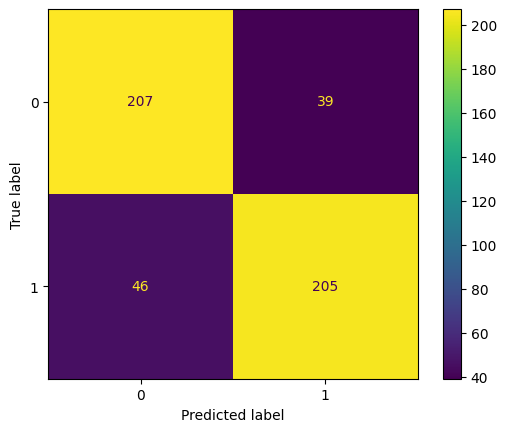

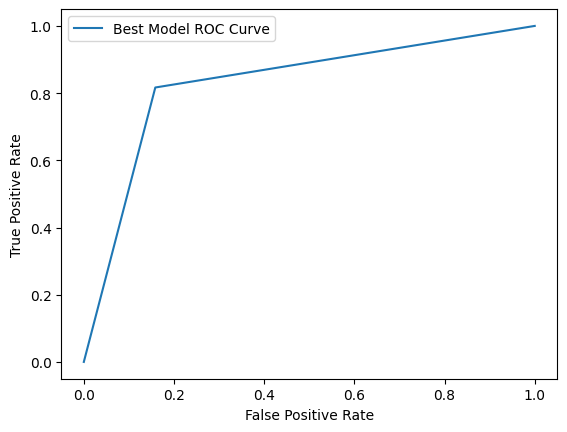

In [ ]:
plot_metrics(y_test, y_pred, model)

## Feature Selection
> Using SelectPercentile to reduce the features from the dataset



In [ ]:
model = make_pipeline(SelectPercentile(chi2, percentile=80), StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

   non-covid       0.82      0.84      0.83       246
       covid       0.84      0.82      0.83       251

    accuracy                           0.83       497
   macro avg       0.83      0.83      0.83       497
weighted avg       0.83      0.83      0.83       497



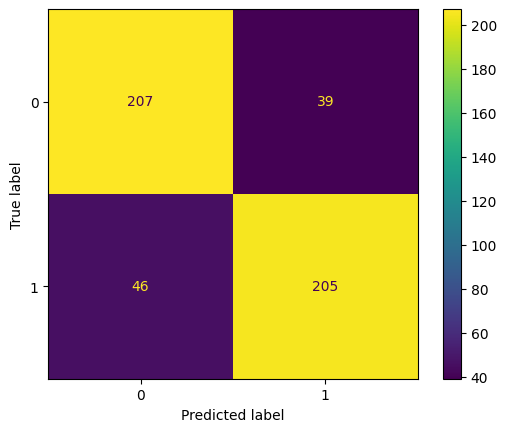

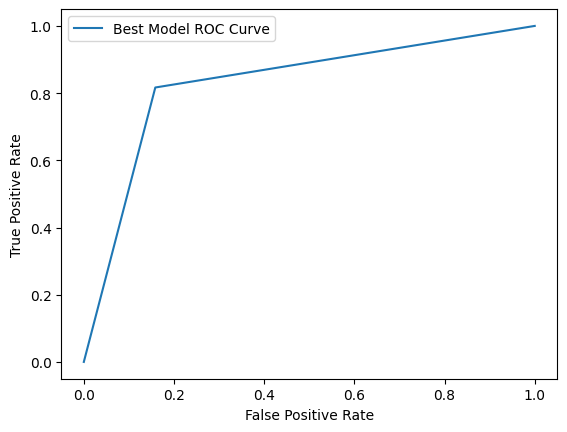

In [ ]:
plot_metrics(y_test, y_pred, model)

## Finding Best H-Params
> Using GridSearch to find the best setup for the model



In [ ]:
model_pipe = Pipeline(
    steps=[
      ('features', SelectPercentile()),
      ('scaler', StandardScaler()),
      ('lr', LogisticRegression())
    ])
parameters = {
    "features__score_func": [chi2, f_classif, mutual_info_classif],
    "features__percentile": [50, 80, 100],
    "lr__penalty": ['l1', 'l2'],
    "lr__solver": ['liblinear'],
    "lr__C": [1., 0.6, 0.3, 0.1],
    "lr__max_iter": [3000, 1000, 100],
}
grid_pipeline = GridSearchCV(model_pipe, parameters, cv=5)
grid_pipeline.fit(X_train, y_train)

y_pred = grid_pipeline.predict(X_test)

In [ ]:
grid_pipeline.best_params_

{'features__percentile': 80,
 'features__score_func': <function sklearn.feature_selection._univariate_selection.chi2(X, y)>,
 'lr__C': 0.1,
 'lr__max_iter': 3000,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [ ]:
print("GridSearch Results")
print()
means = grid_pipeline.cv_results_['mean_test_score']
stds = grid_pipeline.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_pipeline.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

GridSearch Results

0.722 (+/-0.015) for {'features__percentile': 50, 'features__score_func': <function chi2 at 0x7f22de267760>, 'lr__C': 1.0, 'lr__max_iter': 3000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
0.720 (+/-0.010) for {'features__percentile': 50, 'features__score_func': <function chi2 at 0x7f22de267760>, 'lr__C': 1.0, 'lr__max_iter': 3000, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
0.724 (+/-0.021) for {'features__percentile': 50, 'features__score_func': <function chi2 at 0x7f22de267760>, 'lr__C': 1.0, 'lr__max_iter': 1000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
0.720 (+/-0.010) for {'features__percentile': 50, 'features__score_func': <function chi2 at 0x7f22de267760>, 'lr__C': 1.0, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
0.722 (+/-0.020) for {'features__percentile': 50, 'features__score_func': <function chi2 at 0x7f22de267760>, 'lr__C': 1.0, 'lr__max_iter': 100, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
0.720 (+/-0.010)

In [ ]:
pd.DataFrame(grid_pipeline.cv_results_)

              precision    recall  f1-score   support

   non-covid       0.83      0.85      0.84       246
       covid       0.85      0.82      0.84       251

    accuracy                           0.84       497
   macro avg       0.84      0.84      0.84       497
weighted avg       0.84      0.84      0.84       497



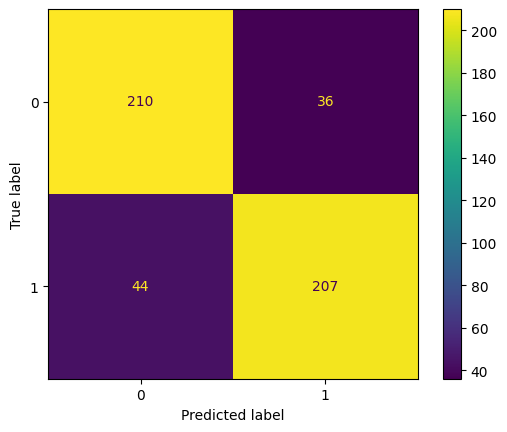

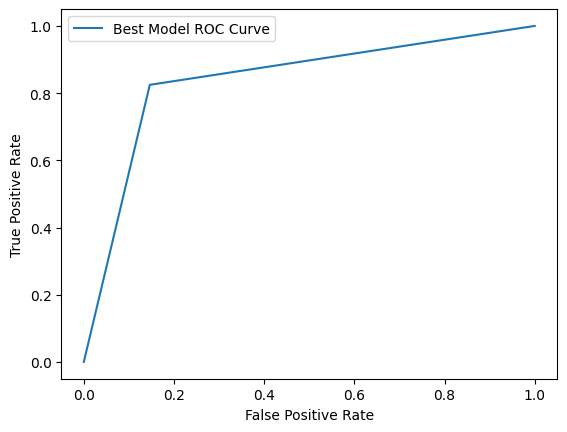

In [ ]:
plot_metrics(y_test, y_pred, model)

## Data Augmentation


> Oversampling the database and run the best model found with GridSearch



In [ ]:
!cd dataset/COVID/ && rm generated_*.png
!cd dataset/non-COVID/ && rm generated_*.png

!rm -rf aug/

!mkdir -p aug/covid_class/
!cp -R dataset/COVID aug/covid_class/

!mkdir -p aug/non_covid_class/
!cp -R dataset/non-COVID aug/non_covid_class/

create_augmentation_for_images(
    from_path=PATH_FOR_IMG_AUGMENTATION_COVID,
    save_to_path=COVID_DATA_PATH,
    n_iter=ITERATIONS_OF_DATA_AUGMENTATION
)
create_augmentation_for_images(
    from_path=PATH_FOR_IMG_AUGMENTATION_NON_COVID,
    save_to_path=NON_COVID_DATA_PATH,
    n_iter=ITERATIONS_OF_DATA_AUGMENTATION
)

data = create_data_frame()
data = random_data_frame(data)
images = load_images(data, in_rgb = 0)
y_targets = data['id_class']

X_train, X_test, y_train, y_test = train_test_split(
    images, y_targets, test_size=0.2, stratify=data['id_class'])

rm: cannot remove 'generated_*.png': No such file or directory
rm: cannot remove 'generated_*.png': No such file or directory
Found 1252 images belonging to 1 classes.
Found 1229 images belonging to 1 classes.
(21648, 64, 64)


21648it [00:20, 1068.07it/s]


Total de imagens carregadas: 21648


In [ ]:
X_train = X_train.reshape(get_reshape_from_2d_to_1d(X_train))
X_test = X_test.reshape(get_reshape_from_2d_to_1d(X_test))


In [ ]:
model = make_pipeline(SelectPercentile(chi2, percentile=80), StandardScaler(), LogisticRegression(C=0.1, max_iter=3000, penalty='l1', solver='liblinear'))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

   non-covid       0.80      0.82      0.81      2147
       covid       0.82      0.79      0.81      2183

    accuracy                           0.81      4330
   macro avg       0.81      0.81      0.81      4330
weighted avg       0.81      0.81      0.81      4330



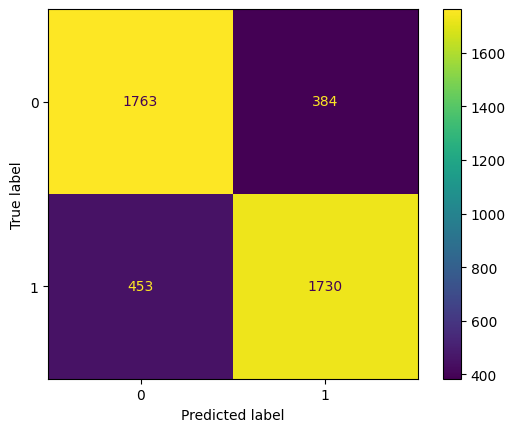

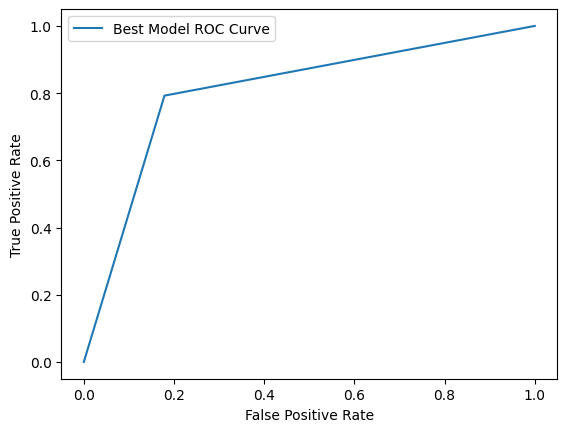

In [ ]:
plot_metrics(y_test, y_pred, model)